In [1]:
## MAlaria Detection using Transfer Learning

# Download The Dataset from 
#https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'cell_images/Train'
valid_path = 'cell_images/Test'

In [4]:
# add preprocessing layer to the front of VGG
# include_top = false means its removing firts and last layer, the last layer has two categories i.e, parasitized and uninfected
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 16s 0us/step


In [5]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [11]:
  # useful for getting number of classes
folders = glob('cell_images/Train/*')
print(len(folders))

2


In [8]:
x = Flatten()(vgg.output)

In [9]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [12]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [13]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('cell_images/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('cell_images/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 416 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [16]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-16-39a22121036e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
13/13 [==============================] - 80s 6s/step - loss: 1.5571 - accuracy: 0.5240 - val_loss: 1.1369 - val_accuracy: 0.6791
Epoch 2/5
13/13 [==============================] - 114s 9s/step - loss: 0.8079 - accuracy: 0.6394 - val_loss: 0.8732 - val_accuracy: 0.5821
Epoch 3/5
13/13 [==============================] - 115s 9s/step - loss: 0.4890 - accuracy: 0.7740 - val_loss: 0.7215 - val_accuracy: 0.6269
Epoch 4/5
13/13 [==============================] - 117s 9s/step - loss: 0.3646 - accuracy: 0.8486 - val_loss: 0.4552 - val_accuracy: 0.7463
Epoch 5/5
13/13 [==============================] - 131s 10s/step - loss: 0.3483 - accuracy: 0.8438 - val_loss: 0.5797 - val_accuracy: 0.6866


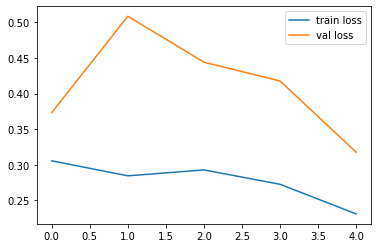

<Figure size 432x288 with 0 Axes>

In [19]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

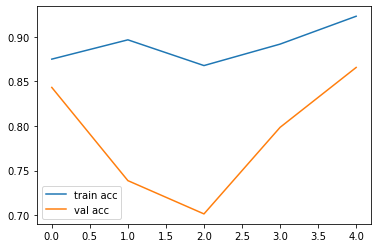

<Figure size 432x288 with 0 Axes>

In [22]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [23]:
import tensorflow as tf

from keras.models import load_model

model.save('model_vgg19.h5')